In [1]:
# Google Play Dataset - Preprocessing
import numpy as np
import pandas as pd
import re

print("=======================================")
print("Pre-processing of dataset")
print("Output: first 5 rows of the result dataset")
print("=======================================")
df = pd.read_csv('../Google-Playstore.csv')

def classify_size_column(value):
    if pd.isna(value) or value == 'Varies with device':
        return np.nan
    match = re.search(r'([0-9.]+)([kMG]?)', str(value))
    if match:
        number, unit = match.groups()
        if unit == 'k':
            return float(number) / 1024
        elif unit == 'G':
            return float(number) * 1024
        else:
            return float(number)
    else:
        return np.nan

def install_groupby(value):
    if value < 100:
        return '0-100'
    elif value < 1000:
        return '100-1k'
    elif value < 10000:
        return '1k-10k'
    elif value < 100000:
        return '10k-100k'
    else:
        return '100k+'

df.drop(['App Id','Developer Id', 'Developer Website', 'Developer Email', 'Privacy Policy', 'Scraped Time'], axis=1, inplace=True)

df['Currency'] = df['Currency'].apply(lambda x: 'USD' if x == 'USD' else 'Others')
df.drop(df[df['Currency'] == 'Others'].index, inplace=True)
df.drop(columns=['Currency'], inplace=True)
df.drop(columns=['Installs'], inplace=True)
df['Name Length'] = df['App Name'].str.len()
df['Minimum Android'] = df['Minimum Android'].str.replace(' and up', '').str.split(' - ').str.get(0)
df['Minimum Android'] = df['Minimum Android'].str.split('.').str.get(0)
# Replace 'Varies with device' with NaN
df['Minimum Android'] = df['Minimum Android'].apply(lambda x: np.nan if x == 'Varies with device' else x)

df['Clean Size'] = df['Size'].apply(classify_size_column)
df['Clean Size'].describe()

# Replace date by age (in days)
df['Released'] = pd.to_datetime(df['Released'], format='%b %d, %Y')
df['Last Updated'] = pd.to_datetime(df['Last Updated'], format='%b %d, %Y')
scraped_time = pd.to_datetime('2021-06-15 00:00:00')
df['App Age'] = (scraped_time - df['Released']).dt.days
# Last update age
df['Last Update Age'] = (scraped_time - df['Last Updated']).dt.days

df['Minimum Installs'] = df['Minimum Installs'].apply(install_groupby)
# Drop 'Installs'
# df.drop(columns=['Installs'], inplace=True)

df.drop(columns=['Released', 'Last Updated'], inplace=True)
df.drop(['Size'], axis=1, inplace=True)
df.drop(['App Name'], axis=1, inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df = df.query('`Maximum Installs` > 0')
df.reset_index(drop=True, inplace=True)
print(df.shape)
print(df.head(5))


Pre-processing of dataset
Output: first 5 rows of the result dataset
(2169743, 16)
        Category  Rating  Rating Count Minimum Installs  Maximum Installs  \
0      Adventure     0.0           0.0            0-100                15   
1          Tools     4.4          64.0           1k-10k              7662   
2   Productivity     0.0           0.0            0-100                58   
3  Communication     5.0           5.0            0-100                19   
4          Tools     0.0           0.0           100-1k               478   

   Free  Price Minimum Android Content Rating  Ad Supported  In App Purchases  \
0  True    0.0               7       Everyone         False             False   
1  True    0.0               5       Everyone          True             False   
2  True    0.0               4       Everyone         False             False   
3  True    0.0               4       Everyone          True             False   
4  True    0.0               4       Everyone    

<Axes: ylabel='Density'>

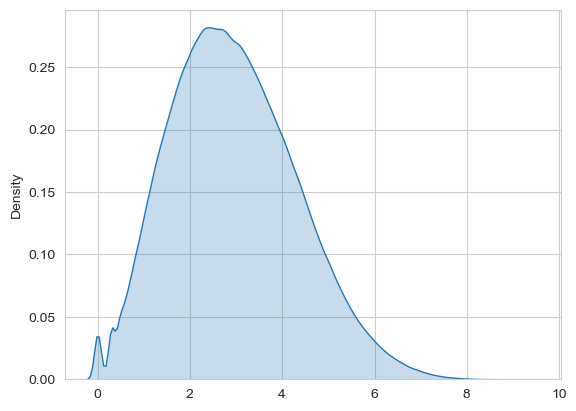

In [2]:
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
import seaborn as sns
sns.kdeplot(data=df, x = np.log10(df['Maximum Installs'].values), fill=True)

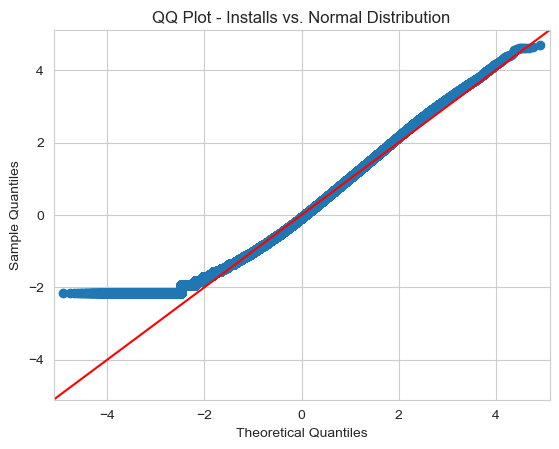

In [3]:
from statsmodels.graphics.gofplots import qqplot
fig = qqplot(np.log10(df['Maximum Installs']), stats.norm, fit=True, line='45')
ax = fig.axes[0]
ax.set_title("QQ Plot - Installs vs. Normal Distribution")
plt.show()

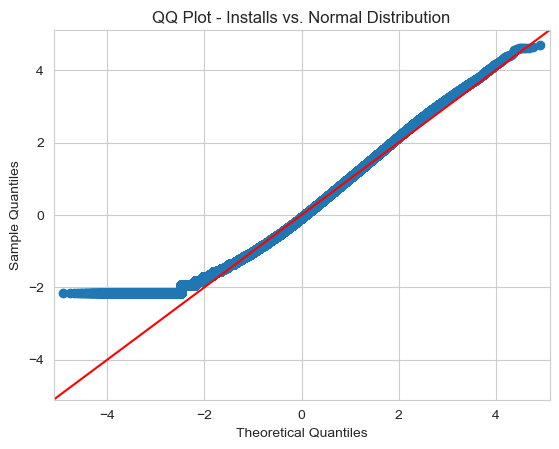

In [4]:
fig = qqplot(np.log10(df['Maximum Installs']), stats.norm, fit=True, line='45')
ax = fig.axes[0]
ax.set_title("QQ Plot - Installs vs. Normal Distribution")
plt.show()

In [5]:
df['Installs Log'] = np.log10(df['Maximum Installs'])

In [6]:
installs_log_q1, installs_log_q3 = np.percentile(df['Installs Log'], [25, 75])
installs_log_iqr = installs_log_q3 - installs_log_q1
installs_log_lower_bound = installs_log_q1 - (1.5 * installs_log_iqr)
installs_log_upper_bound = installs_log_q3 + (1.5 * installs_log_iqr)
df = df.query('`Installs Log` > @installs_log_lower_bound and `Installs Log` < @installs_log_upper_bound')

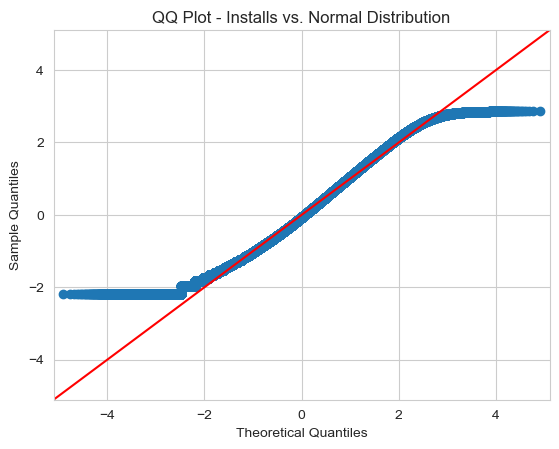

In [7]:
fig = qqplot(np.log10(df['Maximum Installs']), stats.norm, fit=True, line='45')
ax = fig.axes[0]
ax.set_title("QQ Plot - Installs vs. Normal Distribution")
plt.show()